In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import  RandomNormal
from keras.metrics import categorical_accuracy
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold, LeaveOneOut
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Dataset/

[Errno 2] No such file or directory: 'drive/MyDrive/Dataset/FER2013'
/content/drive/MyDrive/Dataset


In [ ]:
!unzip fer2013.zip -d .

Archive:  fer2013.zip
  inflating: ./fer2013.csv           


In [ ]:
%cd FER2013/

/content/drive/My Drive/Dataset/FER2013


**Load the dataset**

In [ ]:
def load_fer2013(force = False):
    """Load the emotion dataset"""
    print("Loading dataset...")
    if not os.path.exists('face_cache.npz') or force:
        print('cache not existing')
        data = pd.read_csv("fer2013.csv")
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            pixs = pixel_sequence.split(' ')
            try:
                face = np.asarray(pixel_sequence.split(
                    ' '), dtype=np.uint8).reshape(width, height)
                face = cv2.resize(face.astype('uint8'), (width, height))
                faces.append(face.astype('float32'))
            except ValueError:
              print("Unable to load face.")
        print('done faces')
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).values
        #emotions = pd.array(data['emotion'])

        split = 0.9
        val_faces = faces[int(len(faces) * split):]
        val_emotions = emotions[int(len(faces) * split):]
        train_faces = faces[:int(len(faces) * split)]
        train_emotions = emotions[:int(len(faces) * split)]
        print('caching')
        np.savez('face_cache.npz', train_faces=train_faces, train_emotions=train_emotions,
                 val_faces=val_faces, val_emotions=val_emotions)
    cached = np.load('face_cache.npz')

    return cached['train_faces'], cached['train_emotions'], cached['val_faces'], cached['val_emotions']

In [ ]:
X_train, y_train, X_test, y_test = load_fer2013(force = True)

Loading dataset...
cache not existing
done faces
caching


In [ ]:
y_train.shape

(30503,)

In [ ]:
X_train /= 255
X_test /= 255

**Build the CNN**

In [ ]:
# Constructing CNN structure
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 23, 23, 64)        36928     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 23, 23, 64)      

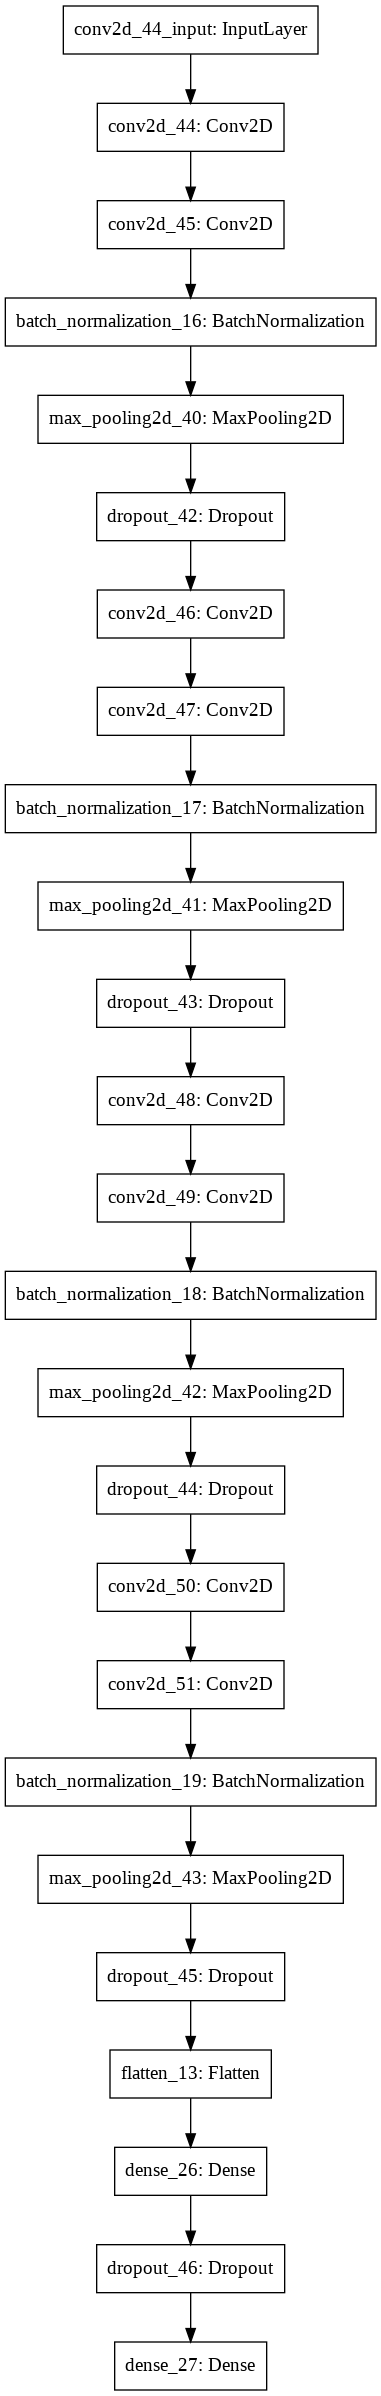

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model2_fer2013.png')

**Data augmentation**

In [ ]:
datagen = ImageDataGenerator(
  featurewise_center=False,  # set input mean to 0 over the dataset
  samplewise_center=False,  # set each sample mean to 0
  featurewise_std_normalization=False,  # divide inputs by std of the dataset
  samplewise_std_normalization=False,  # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
  width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
  height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
  horizontal_flip=True,  # randomly flip images
  vertical_flip=False,
  zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)

**Start Training**

In [ ]:
checkpoint = ModelCheckpoint('checkpoint/best_model2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), epochs=300,steps_per_epoch=X_train.shape[0]/32, validation_data=(X_test, y_test), shuffle=True, callbacks=checkpoint)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
908/908 [==============================] - 21s 20ms/step - loss: 2.6447 - accuracy: 0.2121 - val_loss: 2.0020 - val_accuracy: 0.2349

Epoch 00001: val_loss improved from inf to 2.00202, saving model to checkpoint/best_model2.h5
Epoch 2/300
908/908 [==============================] - 18s 19ms/step - loss: 1.8190 - accuracy: 0.2428 - val_loss: 1.9316 - val_accuracy: 0.2502

Epoch 00002: val_loss improved from 2.00202 to 1.93163, saving model to checkpoint/best_model2.h5
Epoch 3/300
908/908 [==============================] - 17s 19ms/step - loss: 1.8062 - accuracy: 0.2502 - val_loss: 2.0516 - val_accuracy: 0.2352

Epoch 00003: val_loss did not improve from 1.93163
Epoch 4/300
908/908 [==============================] - 18s 19ms/step - loss: 1.8038 - accuracy: 0.2510 - val_loss: 2.3064 - val_accuracy: 0.2352

Epoch 00004: val_loss did not improve from 1.93163
Epoch 5/300
908/908 [==============================] - 18s 19ms/step - loss: 1.7906 - accuracy: 0.2604 - val_loss: 2.0799 

**Visualize Histogram**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


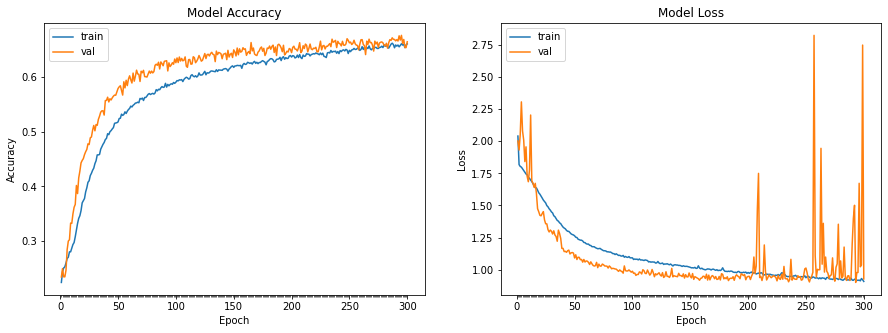

In [ ]:
# visualizing losses and accuracy
%matplotlib inline
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot2.png')
    plt.show()


plot_model_history(hist)

**Load best model**

In [ ]:
model.load_weights("checkpoint/best_model2.h5")
best_model = model

In [ ]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(best_model.predict(test_image))
print(best_model.predict_classes(test_image))
print(y_test[0:1])

#predict
y_pred = best_model.predict(X_test)

Test Loss: 0.9009787440299988
Test accuracy: 0.6748397946357727
(1, 48, 48, 1)
[[0.32347366 0.02191902 0.23865467 0.00054624 0.22608614 0.04620493
  0.14311533]]
[0]
[[1 0 0 0 0 0 0]]


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


**Confusion Matrix**

In [ ]:
names = ['Angry','Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [ ]:
results = best_model.predict_classes(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)

cm_df = pd.DataFrame(cm, index = names,
                     columns = names
                    )
cm_df

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
Angry,281,4,51,10,77,8,60
Disgust,18,28,3,1,1,2,2
Fear,56,3,219,7,128,61,54
Happy,18,3,12,776,18,13,39
Sad,41,2,41,28,347,11,124
Surprise,12,1,40,18,5,327,13
Neutral,12,4,24,21,111,10,444


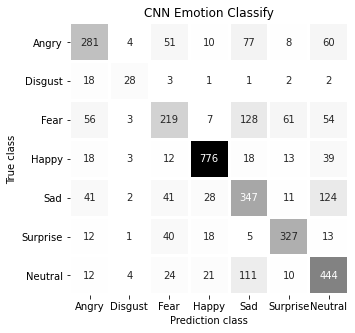

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(cm_df, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

In [ ]:
#Model Save
try:
  os.mkdir('best_model')
except:
  pass
best_model.save('best_model/fer2013_model.h5')